<a href="https://colab.research.google.com/github/nurimateos6/data-mining/blob/feature%2Fpipeline/credit_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
from pandas import read_excel
import numpy as np
import os
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from pylab import rcParams
from collections import Counter

In [ ]:
#pip install imbalanced-learn
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import RandomOverSampler
from imblearn.combine import SMOTETomek
from imblearn.ensemble import BalancedBaggingClassifier

**Carga de datos**

In [ ]:
path = 'C:\\Users\\nmateos\\'
file_name = 'CreditAdmisionDemo-Data.xlsx'
os.path.isfile(path+file_name)

True

In [ ]:
df = read_excel(path + file_name)
print(df.shape)
df.head()

(3168, 21)


,Month_ID,CCAA,First_Submission,SCF_Total_Amount_Financed,Other_Total_Amount_Financed,SCF_Interest_Rate,Other_Interest_Rate_Higher,SCF_Borrowing_Term,Other__Borrowing_Term,SCF_Amortization_Term,...,SCF_Monthly_Payment,Other_Monthly_Payment,SCF_Down_Payment,Other_Down_Payment,SCF_Initial_Credit_Decision_Time_Min,Other_Initial_Credit_Decision_Time_Min,SCF_Promotion_Campaign,Other_Promotion_Campaign,SCF_Funded,Ind_SCF_Funded
0,202007,CATALUÑA,N,34930.32,34969.32,10.50,Yes,84,84.0,84,...,588.0117,600-625,0.0,0.0,10.5,1179.5,No,No,FUNDED,1
1,202007,PAIS VASCO,N,28221.10,29279.04,11.99,Yes,78,84.0,78,...,522.2317,650-675,0.0,0.0,70.7,47.6,No,No,FUNDED,1
2,202007,PAIS VASCO,N,35306.85,0.00,8.99,Yes,72,NaN,72,...,637.0400,750-775,0.0,0.0,86.4,214.3,No,No,FUNDED,1
3,202007,COMUNIDAD DE MADRID,N,27083.87,28044.56,20.99,Yes,78,78.0,78,...,640.1417,475-500,0.0,0.0,3.3,14.2,No,No,FUNDED,1
4,202007,COMUNIDAD DE MADRID,Y,15259.04,14583.30,11.99,Yes,72,66.0,72,...,298.3717,325-350,0.0,0.0,6.4,119.6,No,No,FUNDED,1


**Análisis Exploratorio**

In [ ]:
Other_Monthly_Payment = [ str(x).split('-') for x in df['Other_Monthly_Payment']]
df['Min_Monthly_Payment_New'] = [x[0] for x in Other_Monthly_Payment]
df['Max_Monthly_Payment_New'] = [x[-1] for x in Other_Monthly_Payment]

In [ ]:
cols_replaced = ["Other_Monthly_Payment"]
cols = list(df[df.columns[~df.columns.isin(["Other_Monthly_Payment"])]])
df = df[cols]

**Valores Nulos**

In [ ]:
df["Max_Monthly_Payment_New"] = (df["Max_Monthly_Payment_New"].replace(['nan'], df["Max_Monthly_Payment_New"].median())).apply(pd.to_numeric)

In [ ]:
df["Min_Monthly_Payment_New"] = (df["Min_Monthly_Payment_New"].replace(['nan'], df["Min_Monthly_Payment_New"].median())).apply(pd.to_numeric)

In [ ]:
if df.isnull().values.any():
    print(f'Número de valores nulos: {df.isnull().values.sum()} en columnas: {list(df.columns[df.isnull().any()])} \n ')
    print(f'El número de nulos de cada columna es:\n \
    {pd.DataFrame(df[df.columns[df.isnull().any()]].isnull().sum())} \n \n \
    Cuyo % de nulos del total es: \n \
    {(df[df.columns[df.isnull().any()]].isnull().sum()*100/len(df)).round(3)}')
else:
    print('No hay nulos')

Número de valores nulos: 259 en columnas: ['Other__Borrowing_Term', 'Other_Amortization_Term'] 
 
El número de nulos de cada columna es:
                                0
Other__Borrowing_Term    105
Other_Amortization_Term  154 
 
     Cuyo % de nulos del total es: 
     Other__Borrowing_Term      3.314
Other_Amortization_Term    4.861
dtype: float64


In [ ]:
def remplace_nulls(df, cols:list):
    for col in cols:
        df[col] = df[col].fillna(df[col].median())
    return df

In [ ]:
df = remplace_nulls(df[cols], list(df.columns[df.isnull().any()]))
df.isnull().any()

Month_ID                                  False
CCAA                                      False
First_Submission                          False
SCF_Total_Amount_Financed                 False
Other_Total_Amount_Financed               False
SCF_Interest_Rate                         False
Other_Interest_Rate_Higher                False
SCF_Borrowing_Term                        False
Other__Borrowing_Term                     False
SCF_Amortization_Term                     False
Other_Amortization_Term                   False
SCF_Monthly_Payment                       False
SCF_Down_Payment                          False
Other_Down_Payment                        False
SCF_Initial_Credit_Decision_Time_Min      False
Other_Initial_Credit_Decision_Time_Min    False
SCF_Promotion_Campaign                    False
Other_Promotion_Campaign                  False
SCF_Funded                                False
Ind_SCF_Funded                            False
Min_Monthly_Payment_New                 

**Transformación de Variables**

In [ ]:
Month_ID_New = [ i[-2:] for i in df.Month_ID.astype(str)]
Year_ID_New = [ i[:-2] for i in df.Month_ID.astype(str)]
cols_replaced.append("Month_ID")

In [ ]:
values = [ len(Month_ID_New), len(Year_ID_New)]
if all(v == len(df) for v in values):
    df['Year_ID_New'] = Year_ID_New
    df['Year_ID_New'] = df['Year_ID_New'].apply(pd.to_numeric)
    df['Month_ID_New'] = Month_ID_New
    df['Month_ID_New'] = df['Year_ID_New'].apply(pd.to_numeric)
else:
    print(f'Conversión errónea de la variable. Tiene que haber {len(df)} instancias')

In [ ]:
cols_to_transform = list(df.select_dtypes(exclude=['float','int']).columns)

In [ ]:
import re
aux = cols_to_transform.copy()
for col in cols_to_transform:
    if re.match(pattern='.*_New', string=col):
        aux.remove(str(col))

In [ ]:
cols_replaced.extend(aux)

In [ ]:
import sklearn
from sklearn.preprocessing import LabelEncoder

In [ ]:
def transform_to_numeric(df:pd.DataFrame, colnames:list):
    le = LabelEncoder()
    for col in colnames:
        df[str(col)+'_New'] = pd.DataFrame(le.fit_transform(df[col]))
    return df

In [ ]:
df_new = transform_to_numeric(df, aux)

In [ ]:
df_new['Min_Monthly_Payment_New'].unique()

array([ 600.,  650.,  750.,  475.,  325.,  725.,  700.,  200.,  575.,
        450.,  425.,  500.,  400.,  525.,  775.,  375.,    0.,  250.,
        550., 1175.,  900.,  800., 1300.,  275.,  300.,  625.,  675.,
        175.,  350., 1150., 1250.,  825.,  225., 1825., 1550., 1000.,
       1200., 1875.,  875.,  850.,  975.])

In [ ]:
df_new = df_new[df_new.columns[~df_new.columns.isin(cols_replaced)]]
df_new = df_new[df_new.columns[~df_new.columns.isin(["SCF_Promotion_Campaign_New"])]]

**Correlación de Variables**

In [ ]:
corr_matrix = df_new.corr(method='pearson').round(3)

Text(0.5, 1.0, 'Correlación de variables')

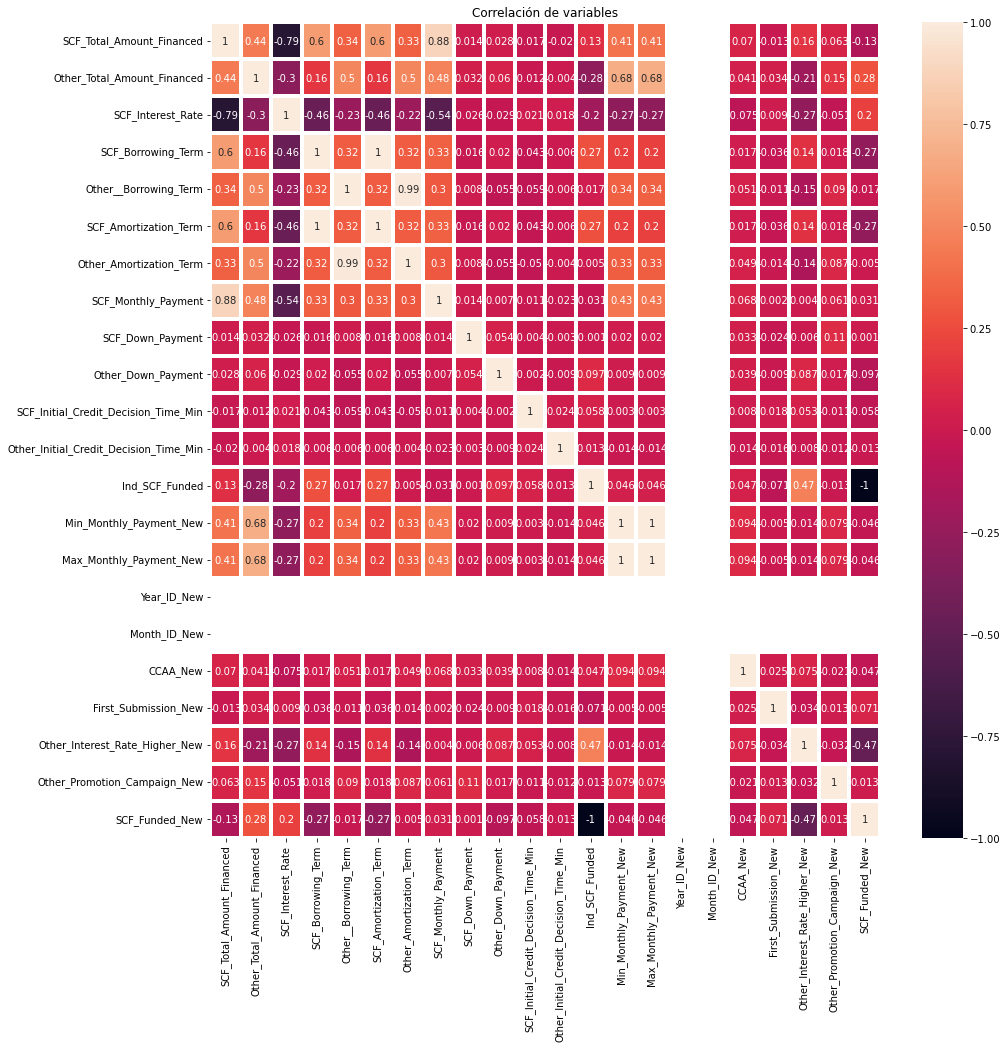

In [ ]:
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(corr_matrix, annot=True, linewidths=-4, ax=ax)
plt.title("Correlación de variables")

In [ ]:
corr_values = corr_matrix.unstack().sort_values(kind="quicksort")

In [ ]:
corr_values[corr_values > 0.6].sort_values(ascending=False)

SCF_Amortization_Term                   SCF_Borrowing_Term                        1.000
                                        SCF_Amortization_Term                     1.000
Other_Interest_Rate_Higher_New          Other_Interest_Rate_Higher_New            1.000
CCAA_New                                CCAA_New                                  1.000
Max_Monthly_Payment_New                 Max_Monthly_Payment_New                   1.000
                                        Min_Monthly_Payment_New                   1.000
Min_Monthly_Payment_New                 Max_Monthly_Payment_New                   1.000
                                        Min_Monthly_Payment_New                   1.000
Ind_SCF_Funded                          Ind_SCF_Funded                            1.000
Other_Initial_Credit_Decision_Time_Min  Other_Initial_Credit_Decision_Time_Min    1.000
SCF_Initial_Credit_Decision_Time_Min    SCF_Initial_Credit_Decision_Time_Min      1.000
Other_Down_Payment              

In [ ]:
corr_values[corr_values < -0.6]

Ind_SCF_Funded             SCF_Funded_New              -1.000
SCF_Funded_New             Ind_SCF_Funded              -1.000
SCF_Interest_Rate          SCF_Total_Amount_Financed   -0.794
SCF_Total_Amount_Financed  SCF_Interest_Rate           -0.794
dtype: float64

Variable a eliminar | Decisión
---|---
SCF_Borrowing_Term  -  SCF_Amortization_Term : 1                 | borrado SCF_Amortization
Other_Amortization_Term - Other__Borrowing_Term : 0.988          | borrado Other_Amortization_Term (porque tiene más std)
SCF_Funded_New - Ind_SCF_Funded : -1.000 (por el label encoder)  | borrado SCF_Funded_New
SCF_Total_Amount_Financed :  SCF_Monthly_Payment : 0.877         | he calculado la correlación entre ambas con el log neperiano (decisión no borrar, porque baja a 0.739)
SCF_Total_Amount_Financed - SCF_Interest_Rate : -0.794 |

In [ ]:
df['Other__Borrowing_Term'].var()

125.27805207107109

In [ ]:
df[['Other__Borrowing_Term', 'Other_Amortization_Term']].describe()

,Other__Borrowing_Term,Other_Amortization_Term
count,3168.000000,3168.000000
mean,74.238636,74.183712
std,11.192768,11.182798
min,24.000000,24.000000
25%,72.000000,72.000000
50%,78.000000,78.000000
75%,84.000000,84.000000
max,84.000000,84.000000


In [ ]:
df[['Other__Borrowing_Term','Other_Amortization_Term']][(df['Other__Borrowing_Term']-df['Other_Amortization_Term'])!=0]

,Other__Borrowing_Term,Other_Amortization_Term
10,84.0,78.0
11,84.0,72.0
16,60.0,48.0
19,60.0,78.0
32,72.0,60.0
...,...,...
424,72.0,78.0
435,72.0,78.0
455,84.0,78.0
461,72.0,78.0


In [ ]:
df1= pd.DataFrame( np.log(df['SCF_Total_Amount_Financed']), columns = ['SCF_Total_Amount_Financed'])
df1['SCF_Monthly_Payment'] =pd.DataFrame( np.log(df['SCF_Monthly_Payment']))

In [ ]:
df1.corr(method='pearson').round(3)

,SCF_Total_Amount_Financed,SCF_Monthly_Payment
SCF_Total_Amount_Financed,1.000,0.739
SCF_Monthly_Payment,0.739,1.000


In [ ]:
df_new = df_new[df_new.columns[~df_new.columns.isin(['SCF_Amortization_Term', 'Other_Amortization_Term', 'SCF_Funded_New'])]]

**Desbalanceo de Clases**

In [ ]:
df_new.Ind_SCF_Funded.value_counts()

0    2702
1     466
Name: Ind_SCF_Funded, dtype: int64

In [ ]:
print(f'El % de instancias para cada clase:\n {df.Ind_SCF_Funded.value_counts(normalize = True)*100}')

El % de instancias para cada clase:
 0    85.290404
1    14.709596
Name: Ind_SCF_Funded, dtype: float64


<AxesSubplot:>

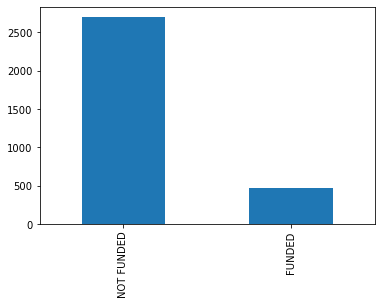

In [ ]:
var = df['SCF_Funded'].value_counts()
var.plot(kind="bar")

**Decisiones para el desbalanceo de clases:**
1. Ajuste de parámetros del modelo:
    - Dentro del propio algoritmo
        - (ajuste de peso en árboles), equilibrio de la clase minoritaria
            logisticregression: parámetro class_weight= “balanced”
            
  
2.  Modificación del dataset:
       - Eliminar muestras de la clase mayoritaria para equilibrar
            Problema: pérdida de muestras importantes e información
            Solución: criterio para la eliminación
       - Agregar nuevas filas con valores de clase minoritaria
            Problema: el modelo puede caer en Overfitting
            
            
3. Crear muestras artificiales o sintéticas:
    - Crear muestras sintéticas (no idénticas) utilizando diversos algoritmos que intentan seguir la tendencia del grupo           minoritario.
        Problema: se puede alterar la distribución natural de la clase y confundir al algoritmo en la clasificación
            
            
4.  Balanced Ensemble Methods:
    - Entrenar diversos modelos y entre todos obtener el resultado final (p.e. con voto). Se asegura de tomar muestras de entrenamiento equilibradas

### SAMPLE

Definición de etiquetas y features

In [ ]:
y = (df_new['Ind_SCF_Funded']).to_numpy()
X = (df_new.drop('Ind_SCF_Funded', axis=1)).to_numpy()

In [ ]:
X_normalized = preprocessing.normalize(X)

División del dataset en sets de entrenamiento y test

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7)
X_train_normalized, X_test, y_train_normalized, y_test = train_test_split(X_normalized, y, train_size=0.7)

## LOGISTIC REGRESSION

### Penalización por compensar en LR

In [ ]:
def run_model(X_train, X_test, y_train, y_test):
    lr = LogisticRegression(C=1.0,penalty='l2',random_state=0, max_iter=1000,class_weight="balanced", solver="lbfgs") # solver lbfgs: porque el dataset es pequeño
    lr.fit(X_train, y_train)
    return lr

In [ ]:
model = run_model(X_train, X_test, y_train, y_test)

C:\Users\nmateos\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
# model = run_model(X_train_normalized, X_test, y_train_normalized, y_test) # Con datos normalizados

In [ ]:
def mostrar_resultados(y_test, pred_y):
    conf_matrix = confusion_matrix(y_test, pred_y)
    plt.figure(figsize=(8, 8))
    labels = ['no founded - 0', 'founded - 1']
    sns.heatmap(conf_matrix, xticklabels=labels, yticklabels=labels,annot=True, fmt="d");
    plt.title("Confusion matrix")
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    plt.show()
    print (classification_report(y_test, pred_y))

In [ ]:
pred_y = model.predict(X_test)


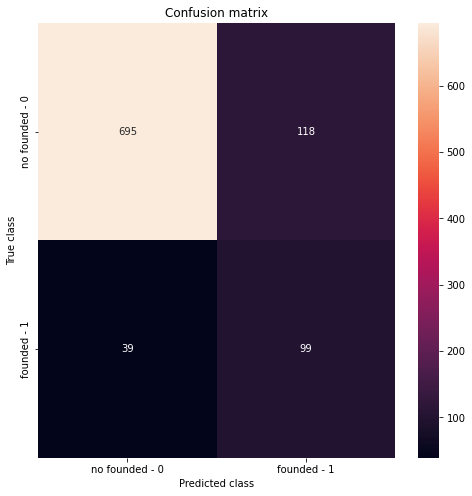

              precision    recall  f1-score   support

           0       0.95      0.85      0.90       813
           1       0.46      0.72      0.56       138

    accuracy                           0.83       951
   macro avg       0.70      0.79      0.73       951
weighted avg       0.88      0.83      0.85       951



In [ ]:
mostrar_resultados(y_test, pred_y)

Procedimiento | Resultado
---|---
Con datos sin normalizar |Recall 0.71 para la clase 1 (founded) (37 fallos y 90 aciertos), por lo que el modelo no es capaz de detectar bien los casos __founded__
Con datos normalizados |Recall 0.57 para la clase 1 (55 fallos y 72 aciertos)

### Subsampling o Reducción clase mayoritaria
CNN - Condensed Nearest Neighbors para seleccionar instancias a eliminar.
Técnica de submuestreo que busca un subconjunto de una colección de muestras que no produce pérdidas en el rendimiento del modelo (conjunto mínimo consistente)

In [ ]:
sampling_strategy = 0.7
undersample = NearMiss(sampling_strategy=sampling_strategy, n_neighbors=3, version=1)
X_train_US, y_train_US = undersample.fit_resample(X_train, y_train)
print(f'Distribución antes del subsampling {Counter(y_train)}')
print(f'Distribución después del subsampling {Counter(y_train_US)}')


Distribución antes del subsampling Counter({0: 1890, 1: 327})
Distribución después del subsampling Counter({0: 467, 1: 327})


C:\Users\nmateos\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


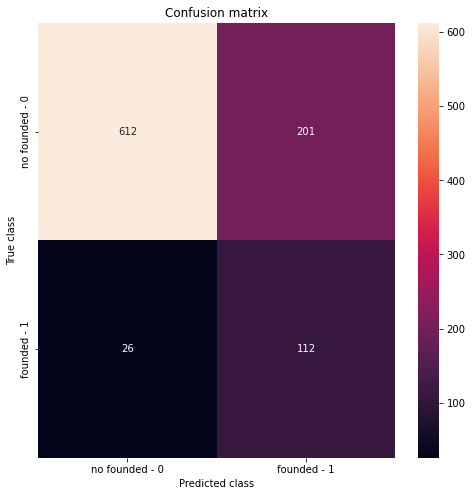

              precision    recall  f1-score   support

           0       0.96      0.75      0.84       813
           1       0.36      0.81      0.50       138

    accuracy                           0.76       951
   macro avg       0.66      0.78      0.67       951
weighted avg       0.87      0.76      0.79       951



In [ ]:
model = run_model(X_train_US, X_test, y_train_US, y_test)
pred_y = model.predict(X_test)
mostrar_resultados(y_test, pred_y)

### Oversampling o creación de muestras sinténticas para la clase minoritaria
CNN - Condensed Nearest Neighbors para seleccionar instancias a eliminar.
Técnica que sobremuestra la clase minoritaria, eligiendo muestras al azar con reemplazo (mediante bootstrap)

Distribución antes del subsampling Counter({0: 1890, 1: 327})
Distribución después del subsamplingCounter({0: 1890, 1: 1890})


C:\Users\nmateos\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


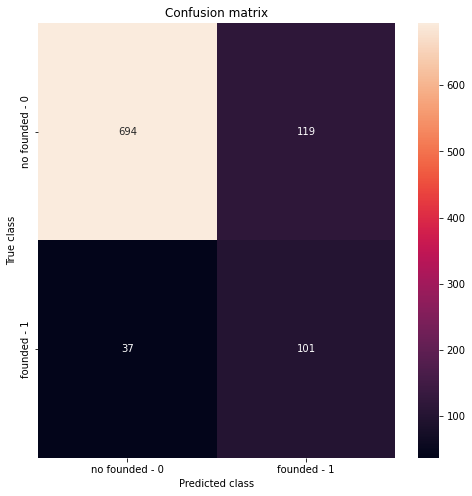

              precision    recall  f1-score   support

           0       0.95      0.85      0.90       813
           1       0.46      0.73      0.56       138

    accuracy                           0.84       951
   macro avg       0.70      0.79      0.73       951
weighted avg       0.88      0.84      0.85       951



In [ ]:
X_train_OS, y_train_OS = RandomOverSampler().fit_resample(X_train, y_train)

print(f'Distribución antes del subsampling {Counter(y_train)}')
print(f'Distribución después del subsampling{Counter(y_train_OS)}')

model = run_model(X_train_OS, X_test, y_train_OS, y_test)
pred_y = model.predict(X_test)
mostrar_resultados(y_test, pred_y)

117 falsos positivos y 35 falsos negativos

#### SMOTE: synthetic minority over-sampling technique
SMOTE funciona seleccionando ejemplos cercanos en el espacio de características, dibujando una línea entre los ejemplos en el espacio de características y dibujando una nueva muestra en un punto a lo largo de esa línea.

Distribución antes del subsampling Counter({0: 1890, 1: 327})
Distribución antes del subsampling Counter({0: 1848, 1: 1848})


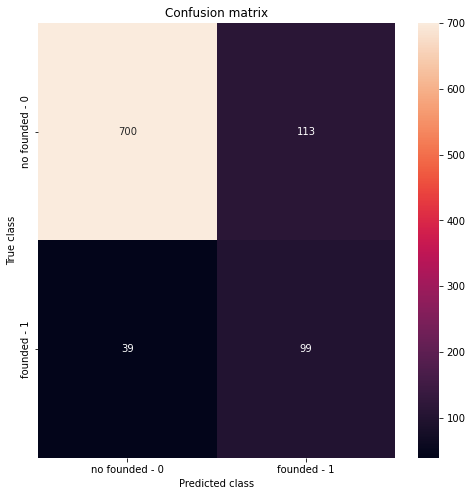

              precision    recall  f1-score   support

           0       0.95      0.86      0.90       813
           1       0.47      0.72      0.57       138

    accuracy                           0.84       951
   macro avg       0.71      0.79      0.73       951
weighted avg       0.88      0.84      0.85       951



In [ ]:
X_train_RE, y_train_RE = SMOTETomek().fit_resample(X_train, y_train)

print(f'Distribución antes del subsampling {Counter(y_train)}')
print(f'Distribución antes del subsampling {Counter(y_train_RE)}')

model = run_model(X_train_RE, X_test, y_train_RE, y_test)
pred_y = model.predict(X_test)
mostrar_resultados(y_test, pred_y)

### Árboles
Ensamblado y voting

Decision Tree

Random Forest

Balanced Random Forest Classifier (para datos no balanceados)

Balanced Bagging (para datos no balanceados)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

In [ ]:
LR = LogisticRegression()
RF = RandomForestClassifier()
SVM = SVC()
voting = VotingClassifier(
 estimators=[('lr', LR), ('rf', RF), ('svc', SVM)],
 voting='hard')
voting.fit(X_train_normalized, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression()),
                             ('rf', RandomForestClassifier()), ('svc', SVC())])

In [ ]:
for clf in (LR, RF, SVM, voting):
    clf.fit(X_train_normalized, y_train_normalized)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.8980021030494216
RandomForestClassifier 0.9327024185068349
SVC 0.9032597266035752
VotingClassifier 0.9032597266035752


#### Balanceo de árboles

In [ ]:
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.metrics import balanced_accuracy_score

In [ ]:
brf = BalancedRandomForestClassifier(n_estimators=100, random_state=0)
brf.fit(X_train, y_train)

BalancedRandomForestClassifier(random_state=0)

In [ ]:
y_pred = brf.predict(X_test)
balanced_accuracy_score(y_test, y_pred)

0.5

In [ ]:
from sklearn.ensemble import BaggingClassifier
from imblearn.ensemble import BalancedBaggingClassifier

balanced_bagging = BalancedBaggingClassifier(n_estimators=50, random_state=0)

balanced_bagging.fit(X_train, y_train)

y_pred = balanced_bagging.predict(X_test)

In [ ]:
print("Balanced Bagging classifier performance:")
print(
    f"Balanced accuracy: {balanced_accuracy_score(y_test, y_pred):.2f}."
)

Balanced Bagging classifier performance:
Balanced accuracy: 0.50.


##### DECISION TREE

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.tree import export_graphviz
from sklearn.tree import export_text
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

In [ ]:
DT = DecisionTreeClassifier( class_weight='balanced', max_depth = 5, random_state=24)

In [ ]:
DT.fit(X, y)

DecisionTreeClassifier(class_weight='balanced', max_depth=5, random_state=24)

Profundidad del árbol: 5
Número de nodos terminales: 18


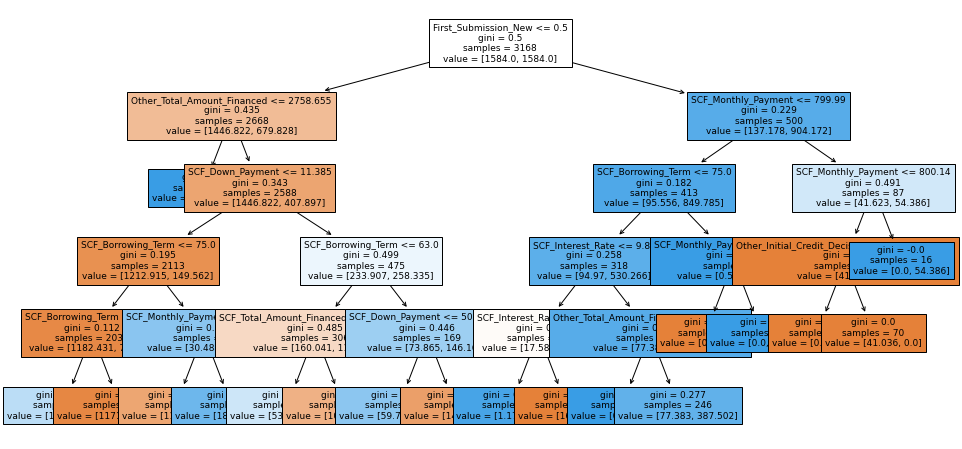

In [ ]:
fig, ax = plt.subplots(figsize=(16, 8))
print(f"Profundidad del árbol: {DT.get_depth()}")
print(f"Número de nodos terminales: {DT.get_n_leaves()}")
plot = plot_tree(
            decision_tree = DT,
            feature_names = df_new.columns.tolist(),
            filled        = True,
            impurity      = True,
            fontsize      = 9,
            ax            = ax
       )

In [ ]:
pred_y = DT.predict(X_test)

Búsqueda por validación cruzada

In [ ]:
param_grid = {'ccp_alpha':np.linspace(0, 5, 10)}

grid = GridSearchCV(
        estimator = DecisionTreeClassifier(
                            max_depth         = None,
                            min_samples_split = 2,
                            min_samples_leaf  = 1,
                            random_state      = 42
                       ),
        param_grid = param_grid,
        scoring    = 'accuracy',
        cv         = 10,
        refit      = True,
        return_train_score = True
      )

Podado del árbol, para encontrar el árbol más sencillo, es decir, con menor tamaño, que consigue mejores resultados para la predicción.
__Nota__: *ccp_alph* determina el grado de penalización por complejidad. Cuanto más grande, más agresivo es el podado, y menor el tamaño del árbol.

{'ccp_alpha': 0.0}

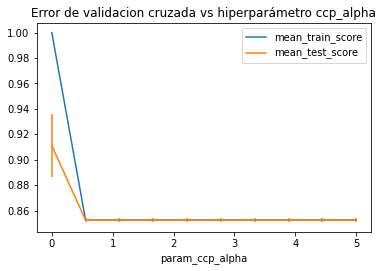

In [ ]:
grid.fit(X_train, y_train)

fig, ax = plt.subplots(figsize=(6, 3.84))
scores = pd.DataFrame(grid.cv_results_)
scores.plot(x='param_ccp_alpha', y='mean_train_score', yerr='std_train_score', ax=ax)
scores.plot(x='param_ccp_alpha', y='mean_test_score', yerr='std_test_score', ax=ax)
ax.set_title("Error de validacion cruzada vs hiperparámetro ccp_alpha");
grid.best_params_

Profundidad del árbol: 18
Número de nodos terminales: 124


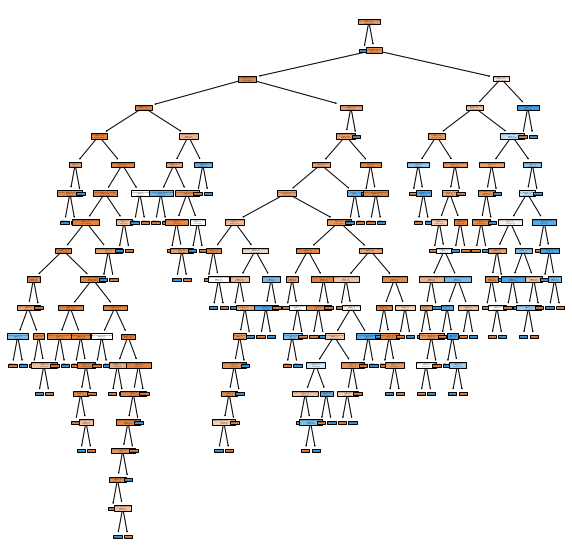

In [ ]:
# Estructura del árbol final
# ------------------------------------------------------------------------------
DT = grid.best_estimator_
print(f"Profundidad del árbol: {DT.get_depth()}")
print(f"Número de nodos terminales: {DT.get_n_leaves()}")

fig, ax = plt.subplots(figsize=(10, 10))
plot = plot_tree(
            decision_tree = DT,
            feature_names = df_new.columns.tolist(),
            filled        = True,
            impurity      = False,
            ax            = ax
       )

In [ ]:
pred_y = DT.predict(X_test)

### Stocastic Gradient Descent

In [ ]:
from sklearn.linear_model import SGDClassifier

In [ ]:
sgd = SGDClassifier(random_state=42)
sgd.fit(X_train, y_train)

SGDClassifier(random_state=42)

In [ ]:
from sklearn.model_selection import cross_val_score,cross_val_predict
from sklearn.model_selection import cross_val_predict


Evaluación del pipeline mediante k-fold cross-validation.

*Nota*: validación cruzada de 10 veces, se aplica 10 veces ajustando y evaluando en el conjunto de datos.

In [ ]:
cross_val_score(sgd, X_train, y_train, cv=10, scoring="accuracy")

array([0.8963964 , 0.87387387, 0.90990991, 0.89189189, 0.87837838,
       0.8963964 , 0.8963964 , 0.88687783, 0.86425339, 0.92307692])

In [ ]:
y_train_pred = cross_val_predict(sgd, X_train, y_train, cv=3)

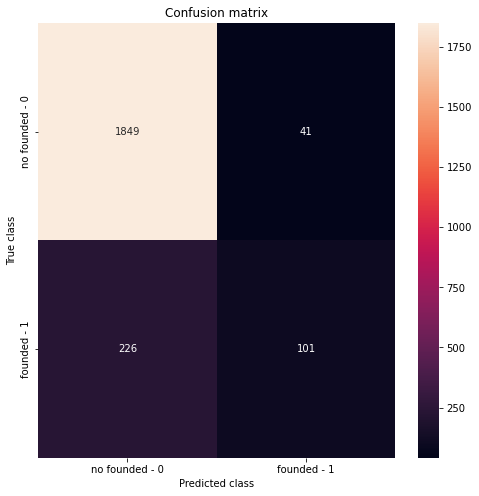

              precision    recall  f1-score   support

           0       0.89      0.98      0.93      1890
           1       0.71      0.31      0.43       327

    accuracy                           0.88      2217
   macro avg       0.80      0.64      0.68      2217
weighted avg       0.86      0.88      0.86      2217



In [ ]:
mostrar_resultados(y_train, y_train_pred)

In [ ]:
y_pred = sgd.predict(X_test)
# mostrar_resultados(y_test, y_pred)

 NN

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.preprocessing import StandardScaler

In [ ]:
def __tranform_data(X, y):
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X)
    X_test = scaler.transform(y)
    return X_train, X_test

In [ ]:
def __create_model(input_layer, dense_layer, output_layer):
    model = Sequential()
    model.add(Dense(input_layer,activation="relu", input_shape=X_train.shape[1:]))
    model.add(Dense(dense_layer, activation="relu"))
    model.add(Dense(output_layer, activation="sigmoid"))
    return model

In [ ]:
def __compile_model(model):
    model.compile(loss="binary_crossentropy",
                optimizer="Adam",
                metrics=[["mse", "accuracy"]])
    return model

In [ ]:
model = __create_model(input_layer=20, dense_layer=20, output_layer=1)
model = __compile_model(model)

In [ ]:
history = model.fit(X_train, y_train, validation_split=.2, epochs=35)

Epoch 1/35
56/56 [==============================] - 0s 4ms/step - loss: 158.3923 - mse: 0.1727 - accuracy: 0.8268 - val_loss: 69.0044 - val_mse: 0.2521 - val_accuracy: 0.7477
Epoch 2/35
56/56 [==============================] - 0s 1ms/step - loss: 28.4246 - mse: 0.1952 - accuracy: 0.8026 - val_loss: 36.0776 - val_mse: 0.2132 - val_accuracy: 0.7815
Epoch 3/35
56/56 [==============================] - 0s 1ms/step - loss: 15.9238 - mse: 0.1703 - accuracy: 0.8274 - val_loss: 32.4140 - val_mse: 0.1904 - val_accuracy: 0.8063
Epoch 4/35
56/56 [==============================] - 0s 1ms/step - loss: 11.3342 - mse: 0.1564 - accuracy: 0.8398 - val_loss: 38.7603 - val_mse: 0.4861 - val_accuracy: 0.5045
Epoch 5/35
56/56 [==============================] - 0s 1ms/step - loss: 12.7339 - mse: 0.1631 - accuracy: 0.8342 - val_loss: 34.8898 - val_mse: 0.1147 - val_accuracy: 0.8851
Epoch 6/35
56/56 [==============================] - 0s 1ms/step - loss: 8.9188 - mse: 0.1491 - accuracy: 0.8483 - val_loss: 33.32

In [ ]:
ms_test = model.evaluate(X_test, y_test)

30/30 [==============================] - 0s 733us/step - loss: 0.6909 - mse: 0.2489 - accuracy: 0.8591


In [ ]:
pred_y = model.predict(X_test)

In [ ]:
# print(confusion_matrix(y_test, pred_y.round(0)))

[[750  63]
 [ 71  67]]


In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

In [ ]:
print(f'Accuracy {acc[:-1]}, \n\n Accuracy es dataset validación{val_acc[:-1]}')

Accuracy [0.8268471360206604, 0.8025944828987122, 0.8274111747741699, 0.8398194909095764, 0.8341793417930603, 0.8482797741889954, 0.8443316221237183, 0.8319233059883118, 0.843203604221344, 0.8426395654678345, 0.8353073596954346, 0.8539199233055115, 0.8364354372024536, 0.8341793417930603, 0.8465877175331116, 0.8448956608772278, 0.8437676429748535, 0.8426395654678345, 0.843203604221344, 0.8409475684165955, 0.8606880903244019, 0.8494077920913696, 0.8307952880859375, 0.8505358099937439, 0.8471516966819763, 0.8567399978637695, 0.8494077920913696, 0.8556119799613953, 0.8448956608772278, 0.8471516966819763, 0.8403835296630859, 0.8584320545196533, 0.8454596996307373, 0.8584320545196533], 

 Accuracy es dataset validación[0.7477477192878723, 0.7815315127372742, 0.8063063025474548, 0.5045045018196106, 0.8851351141929626, 0.8851351141929626, 0.8828828930854797, 0.9031531810760498, 0.8986486196517944, 0.8918918967247009, 0.8918918967247009, 0.7342342138290405, 0.8828828930854797, 0.770270287990570